In [1]:
## This code is still very messy!
#!jupyter nbextension enable --py --sys-prefix widgetsnbextension
%matplotlib inline
#%matplotlib widget
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
import os,time,subprocess,glob,re
import pydicom as dicom
import pandas as pd
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches
from sklearn import manifold
#import umap
from sklearn import preprocessing,tree
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report,precision_recall_fscore_support
#import PersistenceImages.persistence_images as pimg
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import persim
import cripser
import seaborn as sns
from lung_whole_batch import *
#import pervect

sns.set()
#sns.set_style("whitegrid", {'grid.linestyle': '--'})

num = lambda val : int(re.sub("\\D", "", val)) # sorter

In [2]:
# plot persistence image or PD
def plotPD(idx, plotPD=False):
    n = len(idx)
    for i in range(n):
        for d in [0,1,2]:
            if plotPD:
                u = pds[idx[i]][pds[idx[i]][:,0] == d]
                ax = plt.subplot(3,n,i+1+d*n)
                persim.plot_diagrams(u[:,1:3],ax=ax,xy_range=[m,M,m,M],legend=False, lifetime=True)
            else:
                ax = plt.subplot(3,n,i+1+d*n)
                u = np.log(pims_d[idx[i],d])
                ax.imshow(u)

# plot LDA vectors
def biplot(score,Y,coeff,labels=None,textLabel=False,n_comp=4, size=20):
    xs = score[:,0]
    ys = score[:,1]
    if(len(set(Y)))<5:
        cols = ['r','b','k','g','y']
        c = [cols[i] for i in Y]
        discrete_colour = True
    else:
        cNorm  = colors.Normalize(vmin=0, vmax=max(Y))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('rainbow'))
        c = [scalarMap.to_rgba(i) for i in Y]
        discrete_colour = False

    plt.scatter(xs ,ys, s=size, color=c)
    if textLabel:
        from adjustText import adjust_text
        adtx = []
        for k in range(len(X)):
            plt.annotate(k, xy=(X[k,0], X[k,1]))
            adtx.append(plt.annotate(k, xy=(X[k,0], X[k,1]), fontsize=8))
        adjust_text(adtx, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    if coeff is not None:
        N = np.argsort(np.linalg.norm(coeff,axis=1))[::-1]
        norm = np.linalg.norm(coeff[N[0]])
    for i in range(n_comp): # largest variable directions
        vx, vy = 2*coeff[N[i]][:2]/norm
#        print(N[i],coeff[N[i],0], coeff[N[i],1])
        plt.arrow(0, 0, vx,vy,color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(vx* 1.15, vy * 1.15, "v"+str(N[i]), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(vx* 1.15, vy * 1.15, labels[N[i]], color = 'g', ha = 'center', va = 'center')

    # legend
    if(discrete_colour):
        recs = []
        for i in range(len(le.classes_)):
            recs.append(mpatches.Rectangle((0,0),1,1,fc=cols[i]))
        plt.legend(recs,le.classes_,loc=0)
    else:
        plt.colorbar(scalarMap)
    #plt.xticks([])
    #plt.yticks([])

    #plt.xlabel("LD{}".format(1))
    #plt.ylabel("LD{}".format(2))
    #plt.grid()



In [3]:
#%% shallow decision tree classifier for PD
def tree_clf(pims_m,Y,depth=2,verbose=False,plot_roc=False):
    clf = tree.DecisionTreeClassifier(max_depth=depth,criterion="gini",random_state=0)
    #clf = RandomForestClassifier(max_depth=3, n_estimators=400, random_state=0, oob_score=True)
    clf.fit(pims_m,Y)
    if(len(clf.tree_.value)==3):
        above = (clf.tree_.value[1][0][0] > clf.tree_.value[1][0][1])
#        print(above,(clf.tree_.value[1][0]))
    else:
        above = True
    #proba = clf.oob_decision_function_
    proba = clf.predict_proba(pims_m)
    oob_pred=proba.argmax(axis=1)
    rep = precision_recall_fscore_support(Y,oob_pred,zero_division=0)
    #rep = classification_report(Y,oob_pred,output_dict=True)
    acc = sum(Y==oob_pred)/len(Y)

    if verbose:
        print("Confusion matrix\n",confusion_matrix(Y,oob_pred))
        print(classification_report(Y,oob_pred,digits=4))
        id = np.where((Y != oob_pred))
        error1 = [(i,names[i],le.classes_[oob_pred[i]],weight[i]) for i in id[0]]
        np.savetxt("error.csv",np.array(error1),fmt='%s',delimiter=",")
        plt.figure(figsize=(14,10))
        tree.plot_tree(clf,feature_names=fname,class_names=le.classes_) 
        plt.savefig("tree.jpg")
    #print(error1)
    if plot_roc:
        plt.close()
        fp, tp, th = roc_curve(Y, proba[:,1])
        plt.plot(fp, tp, marker='o')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.grid()
        plt.savefig("ROC_emp.jpg")
        print("AUC: {}".format(roc_auc_score(Y, proba[:,1])))
        #print("FP rate for 90% recall",fp[np.min(np.where(tp > 0.9))])
        print("TP rate for 99% precision",tp[np.max(np.where(fp < 0.01))])

    return(acc,rep,clf.tree_.threshold, above)

  0%|          | 0/135 [00:00<?, ?it/s]

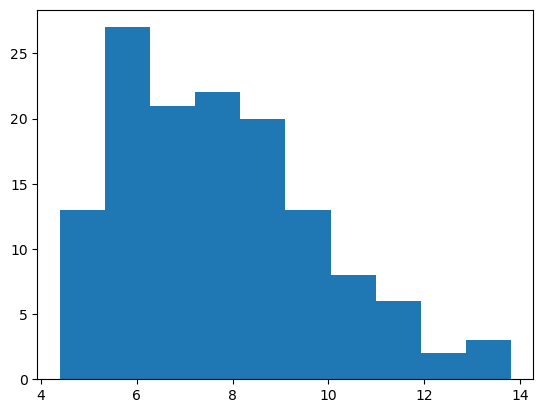

In [30]:
#%% load volumes and load/compute PH
num_cores = multiprocessing.cpu_count()
crop = None
recompute_PH = False
mode = 'ROI'
#mode = 'All'
roi_size = 25

pds = []
vols = []

def task(i):
    fn_pd = os.path.join(root_pd,names[i])+"_pd.npy"
    if os.path.isfile(fn_pd) and not recompute_PH:
        return(np.load(fn_pd))
    else:
        pd = cripser.computePH(vols[i])
        np.save(fn_pd,pd)
        return(pd)


if mode=="All": ## whole Lung
    root = os.path.expanduser("~/CT/ipf/npy/") ## whole lung
    root_pd = root
    dat = pd.read_csv("data/idlist.csv",header=0)
    names = dat['name'].tolist()
    le = preprocessing.LabelEncoder()
    le.fit(dat['label'])
    col = le.transform(dat['label'])
    root_pd = root
    weight=[]
    for i in tqdm(range(len(names))):
        f = names[i]
        fn_pd = os.path.join(root_pd,f)+".npy_pd.npz"
        if os.path.isfile(fn_pd):
            pds.append(np.load(fn_pd)['pd'])
        else:
            v = np.load(os.path.join(root,f)+".npz")['vol']
            pds.append(cripser.computePH(v))
            np.save(fn_pd,pds[-1])
    weight = (512**3)/dat['volume'].values 
    plt.hist(weight)

elif mode=="ROI": ## ROI
    root = "ROI{}".format(roi_size)
    root_pd = root+'_pd'
    os.makedirs(root_pd,exist_ok=True)
    #names = [l for l in pd.read_csv("names.csv",header=None).values.flatten()]
    names = [os.path.splitext(os.path.splitext(fname)[0])[0] for fname in sorted(os.listdir(root)) if fname.endswith(".npy")]
#    names = [fn for fn in names if not "non" in fn]  ## remove non-specific
    label=[l[:3] for l in names]
    le = preprocessing.LabelEncoder()
    le.fit(label)
    col = le.transform(label)
    print(le.classes_,np.unique(col,return_counts=True)[1])

    for i in range(len(names)):
        f = names[i]
#        print(f)
        v = np.load(os.path.join(root,f)+".npy")
        if v.shape != (s,s,s):
            print(i,f,v.shape)
            break
        if crop is not None:
            x,y,z = v.shape
            h = crop //2
            v = v[ (x//2-h):(x//2+h+1), (y//2-h):(y//2+h+1), (z//2-h):(z//2+h+1) ]
        vols.append(v)
    vols = np.stack(vols)

    with ThreadPoolExecutor(num_cores) as e:
        pds = list(tqdm(e.map(task, np.arange(len(names))), total=len(names)))

    # multiplication factor accounting for the volume inside lung
    weight = np.prod(vols.shape[1:])/np.sum( (vols>-2048).reshape(len(vols),-1),axis=1)
    print(vols.shape)
    plt.hist(weight)
else:
    print("Select ROI or All mode")

  0%|          | 0/543 [00:00<?, ?it/s]

['emp' 'fib' 'non' 'nor']
Confusion matrix
 [[107   0  25]
 [  9 160  13]
 [  4   9 216]]
              precision    recall  f1-score   support

           0     0.8917    0.8106    0.8492       132
           1     0.9467    0.8791    0.9117       182
           2     0.8504    0.9432    0.8944       229

    accuracy                         0.8895       543
   macro avg     0.8963    0.8777    0.8851       543
weighted avg     0.8927    0.8895    0.8892       543



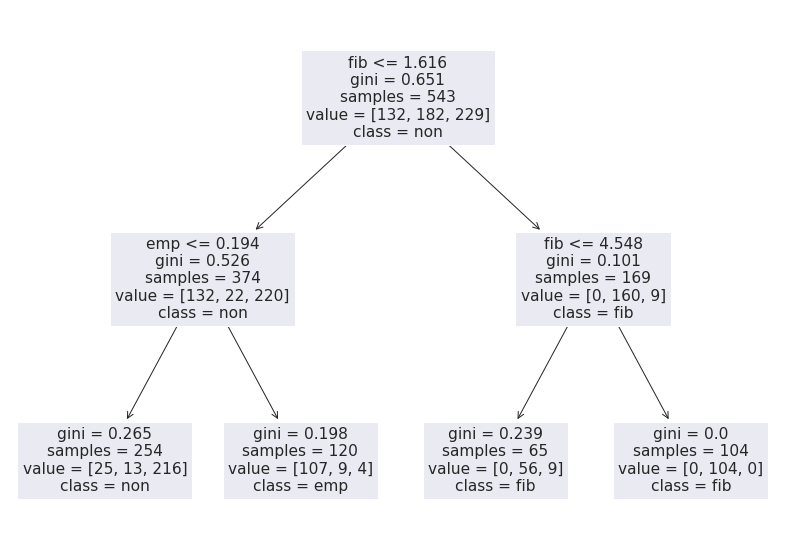

In [10]:
# ROI classification using cycle density
if mode=="ROI":
    h=12
    pims_m = np.zeros( (len(pds),2))
    for i in tqdm(range(len(pds))):
        cc = cycle_count(vols[i],pds[i],cond,h=h,sigma=10.0,gpu_id=0,conv=True, verbose=False)
        pims_m[i] = cc[:,h+1,h+1,h+1]
    fname = ['fib','emp']
    print(le.classes_)
    col[col>2]=2
    res = tree_clf(pims_m,col,depth=2,verbose=True,plot_roc=False)

In [11]:
# cycle density threshold
th=[1.0,8.5]
pred = np.zeros(len(col))
pred[pims_m[:,0]>th[0]]=1
pred[(pims_m[:,0]<=1)*(pims_m[:,1]<=th[1])]=2
print(le.classes_[:3])
print(confusion_matrix(col,pred))
print(classification_report(col,pred,digits=4))
result=classification_report(col,pred,digits=4,output_dict=True)
print(np.unique(col[pims_m[:,0]>th[0]],return_counts=True))
print(np.unique(col[pims_m[:,0]<=th[0]],return_counts=True))
print(np.unique(col[ (pims_m[:,0]<=th[0])*(pims_m[:,1]>th[1])  ],return_counts=True))
print(np.unique(col[ (pims_m[:,0]<=th[0])*(pims_m[:,1]<=th[1])  ],return_counts=True))


['emp' 'fib' 'non']
[[ 57   0  75]
 [  0 170  12]
 [  1  24 204]]
              precision    recall  f1-score   support

           0     0.9828    0.4318    0.6000       132
           1     0.8763    0.9341    0.9043       182
           2     0.7010    0.8908    0.7846       229

    accuracy                         0.7937       543
   macro avg     0.8534    0.7522    0.7630       543
weighted avg     0.8283    0.7937    0.7798       543

(array([1, 2]), array([170,  24]))
(array([0, 1, 2]), array([132,  12, 205]))
(array([0, 2]), array([57,  1]))
(array([0, 1, 2]), array([ 75,  12, 204]))


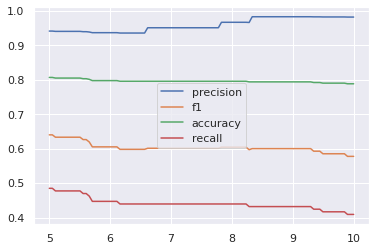

In [12]:
# plot dependence to threshold
prec = []
f1 = []
acc = []
rec = []
xr=np.linspace(5,10,100)
for i in xr:
    th=[1,i]
    pred = np.zeros(len(col))
    pred[pims_m[:,0]>th[0]]=1
    pred[(pims_m[:,0]<=th[0])*(pims_m[:,1]<=th[1])]=2
    result=classification_report(col,pred,digits=4,output_dict=True)
    prec.append(result['0']['precision'])
    rec.append(result['0']['recall'])
    f1.append(result['0']['f1-score'])
    acc.append(result['accuracy'])
               
plt.plot(xr,prec,label="precision")
plt.plot(xr,f1,label="f1")
plt.plot(xr,acc,label="accuracy")
plt.plot(xr,rec,label="recall")
plt.legend()


In [14]:
#%% grid search for characteristic cycles in the persistence diagram with decision tree
target = 0
print("classes: ", le.classes_,"target: ", le.classes_[target])
idx = np.arange(len(col))
#idx = np.where(np.logical_or((col==0),(col==2)))[0]
Y = col[idx]==target
#Y = np.logical_or((col==0),(col==2))

#d0_min,d0_max,d1_min,d1_max = -900,300,-900,300
b0_min,b0_max,b1_min,b1_max,step, dims = -1200,100,-1200,100,100, [0,1,2] # all
#b0_min,b0_max,b1_min,b1_max,step, dims = -1700,-1300,-700,-350,10, [0] #
#b0_min,b0_max,b1_min,b1_max,step, dims = -800,-600,-200,-0,10, [1] #fib
#b0_min,b0_max,b1_min,b1_max,step, dims = -800,-600,-100,100,10, [1] #fib old
#b0_min,b0_max,b1_min,b1_max,step, dims = -1200,-900,-1100,-800,50, [0,1,2] #emp

d0_min, d0_max, d1_min, d1_max = -1200,400, -500,400
#d0_min, d0_max, d1_min, d1_max = -1300,-800, -1000,-800
l_min, l_max, l_step = 250,400,50
#l_min, l_max, l_step = 20,100,10
d0,d1 = -2000, 1000

params = []
for d in dims:
    for b0 in np.arange(b0_min,b0_max,step):
        for b1 in np.arange(max(b0+step,b1_min),b1_max,step):
            for l in np.arange(l_min,l_max,l_step):
#                for d0 in np.arange(max(b0+l,d0_min),min(b1+l,d0_max),step):
#                    for d1 in np.arange(max(d1_min,b1+l),d1_max,step):    
                        params.append((d,b0,b1,d0,d1,l))

def task(param):
    d,b0,b1,d0,d1,l = param
    pims_m = np.zeros( (len(Y),1 ))
    for i,j in enumerate(idx):
        p = pds[j]
        life = np.clip(p[:,2]-p[:,1],0,800)
#        pims_m[i,0] = np.sum( (p[:,0]==d)*(b0<p[:,1])*(p[:,1]<b1)*(life>l))
#        pims_m[i,0] = np.sum( (p[:,0]==d)*(b0<p[:,1])*(p[:,1]<b1)*(np.maximum(life-l,0)))  # weighted
        pims_m[i,0] = np.sum( (p[:,0]==d)*(b0<p[:,1])*(p[:,1]<b1)*(d0<p[:,2])*(p[:,2]<d1)*(life>l))
#        pims_m[i,1] = np.sum( (p[:,0]==0)*(-810<p[:,1])*(p[:,1]<-770)*(life>15) ) # fib
#        pims_m[i,2] = np.sum( (p[:,0]==0)*(-1140<p[:,1])*(p[:,1]<-1020)*(life>10) ) # emp
        pims_m[i] *= weight[i]
    acc,rep, th, above = tree_clf(pims_m,Y,depth=1,verbose=False,plot_roc=False)
    score = rep[2][1] #f1
    #score = acc
    if not above:
        score = -score
    if score>0.98:
        print([score,th[0],d,b0,b1,d0,d1,l])
    return([score,th[0],d,b0,b1,d0,d1,l])

with ThreadPoolExecutor(num_cores) as e:
    ret = list(tqdm(e.map(task, params), total=len(params)))

R = np.array(list(ret))
ranking = np.argsort(R[:,0])[::-1]
np.set_printoptions(floatmode='fixed',precision=4,suppress=True)
print(R[ranking[:10]])
np.savetxt("ROI{}_perf_{}_nod_{}.csv".format(s,le.classes_[target],step),R[ranking],delimiter=",",fmt="%.4f")



['emp' 'fib' 'non' 'nor'] emp
702


  0%|          | 0/702 [00:00<?, ?it/s]

[[    0.1111     1.0955     2.0000  -800.0000  -700.0000 -2000.0000
   1000.0000   250.0000]
 [    0.0966     0.5000     2.0000  -700.0000  -600.0000 -2000.0000
   1000.0000   350.0000]
 [    0.0299     1.8468     2.0000  -700.0000  -500.0000 -2000.0000
   1000.0000   350.0000]
 [    0.0299     3.6270     1.0000 -1100.0000 -1000.0000 -2000.0000
   1000.0000   300.0000]
 [    0.0299     3.6270     1.0000 -1100.0000 -1000.0000 -2000.0000
   1000.0000   350.0000]
 [    0.0299     3.6270     1.0000 -1200.0000 -1000.0000 -2000.0000
   1000.0000   300.0000]
 [    0.0299     3.6270     1.0000 -1200.0000 -1000.0000 -2000.0000
   1000.0000   350.0000]
 [    0.0150     0.5000     2.0000 -1200.0000  -800.0000 -2000.0000
   1000.0000   300.0000]
 [    0.0150     1.8468     2.0000  -600.0000  -500.0000 -2000.0000
   1000.0000   350.0000]
 [    0.0150     0.5000     1.0000  -100.0000     0.0000 -2000.0000
   1000.0000   350.0000]]


characteristic cycles: dim=2, birth_low=-800.0, birth_high=-700.0, death_low=-2000.0, death_high=1000.0
['emp' 'fib' 'non' 'nor']
Confusion matrix
 [[110  17   5]
 [ 11  96  75]
 [ 12  62 155]]
              precision    recall  f1-score   support

           0     0.8271    0.8333    0.8302       132
           1     0.5486    0.5275    0.5378       182
           2     0.6596    0.6769    0.6681       229

    accuracy                         0.6648       543
   macro avg     0.6784    0.6792    0.6787       543
weighted avg     0.6631    0.6648    0.6638       543



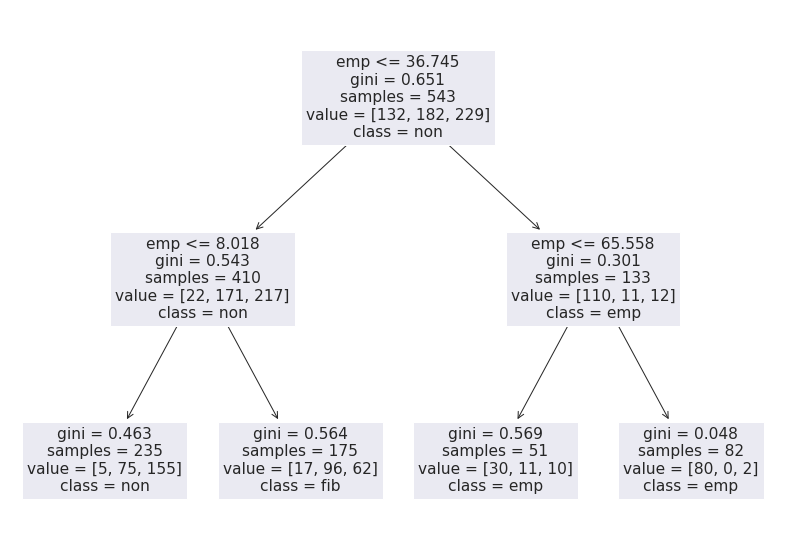

In [17]:
#%% plot decision tree
fname = ['fib','emp','dummy']
idx = np.arange(len(col))
target = 0
idx = np.where(col != 4)[0]
#idx = np.where(np.logical_or((col==0),(col==2)))[0]
Y = col[idx]#==target
#Y = np.logical_or((col==0),(col==2))

d,b0,b1,d0,d1,l=0,-1200,-800,-2000,-400,370
d,b0,b1,d0,d1,l = R[ranking[0],2:]
print("characteristic cycles: dim={}, birth_low={}, birth_high={}, death_low={}, death_high={}".format(int(d),b0,b1,d0,d1,l))
pims_m = np.zeros( (len(Y),2))
for i,j in enumerate(idx):
    p = pds[j]
    life = np.clip(p[:,2]-p[:,1],0,800)
    pims_m[i,0] = np.sum( (p[:,0]==d)*(b0<p[:,1])*(p[:,1]<b1)*(d0<p[:,2])*(p[:,2]<d1)*(life>l) )
#    pims_m[i,0] = np.sum( (p[:,0]==d)*(b0<p[:,1])*(p[:,1]<b1)*(np.maximum(life-l,0)))  # weighted
#   pims_m[i,1] = np.sum( (p[:,0]==2)*(-1020<p[:,1])*(p[:,1]<-900)*(life>10)*(life<200) ) # emp
    pims_m[i,1] = np.sum( (p[:,0]==0)*(-1100<p[:,1])*(p[:,1]<-900)*(-1020<p[:,2])*(p[:,2]<-970)*(life>80) ) # emp50
    pims_m[i] *= weight[i]

print(le.classes_)
res = tree_clf(pims_m,Y,depth=2,verbose=True,plot_roc=False)


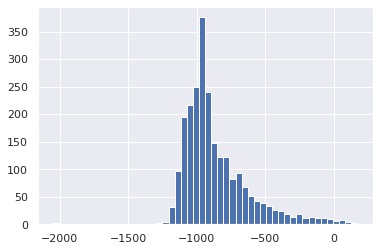

In [20]:
hs = plt.hist(pds[300][:,1],bins=50) # histogram of birth time


#Below is mainly for mode="All"

In [ ]:
#%% compute persistence image
m,M=-1700,300
h=20
max_life=1000
clip = False
weight_correction = False

prefix = '{}m{}M{}'.format(ROI,m,M)

# pers_range can be bigger?
pim = pimg.PersistenceImager(birth_range=(m,M), pers_range=(0,max_life),pixel_size=(M-m)/h)
#pim = persim.PersImage(pixels=[30,11], spread=1, specs={"minBD": m, "maxBD": M})

n = len(pds)

# birth-lifetime format
pds_b_l = []
for d in [0,1,2]:
    pds_b_l.append([])   
    for i in range(n):
        p = (pds[i][pds[i][:,0]==d])[:,1:3]
        if clip:
            life = np.clip(p[:,1]-p[:,0],a_min=None,a_max=max_life)
    #        p = np.clip(p,a_min=m,a_max=None) # lower clip
            p[:,1] = p[:,0]+life
        pds_b_l[d].append(p)
        
pims =[]
for d in [0,1,2]:
    print("Computing for dimension: ",d)
#    pim = pervect.PersistenceVectorizer().fit(pds_b_l[d])
    with ThreadPoolExecutor(num_cores) as e:
        ret = list(tqdm(e.map(pim.transform, pds_b_l[d]), total=n))
    if weight_correction:
        pims.append([w*r for r,w in zip(ret,weight)])
    else:
        pims.append(ret)

pims_d = np.stack(pims)

np.save(prefix+"_pims.npy".format(d),pims_d.transpose(1,0,2,3))

In [31]:
#%% load computed persistence images
m,M=-1700,300
skip = 2
prefix = 'data/{}m{}M{}'.format(mode,m,M)
dim = [0,1,2]
pims_d = np.load(prefix+"_pims.npy")
#pims_d = np.sqrt(pims_d)
pims_d_sub = pims_d[:,dim,::skip,::skip]
mask = (pims_d_sub.max(axis=0)>1e-2)
pims = pims_d_sub[:,mask]
print(pims_d.shape,pims.shape)
#print(mask)

(135, 3, 20, 10) (135, 110)


In [ ]:
id1 = np.where(col==1)[0]
plotPD(id1[4:8],True)

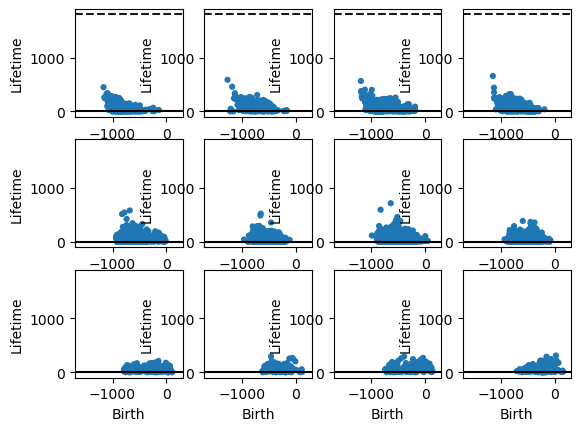

In [24]:
id2 = np.where(col==2)[0]
plotPD(id2[4:8],True)

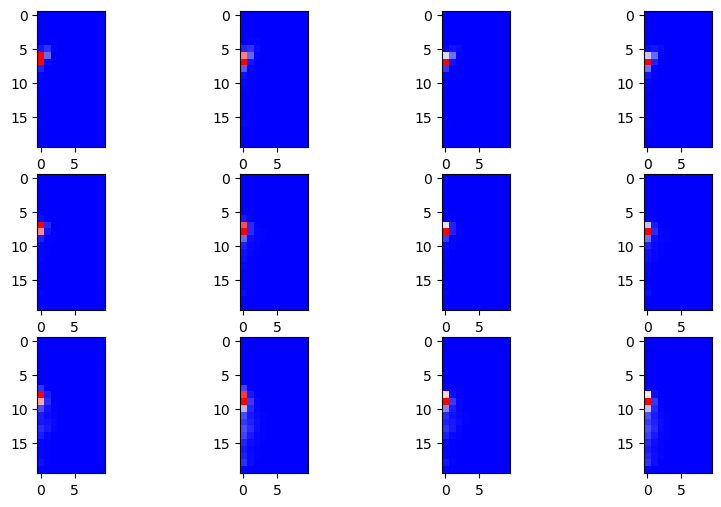

In [33]:
#%%  plot mean persistence images [H_0,H_1,H_2]: each column corresponds to each class
mean_pims =[]
n_class = len(le.classes_)
for d in [0,1,2]:
    mean_pims.extend([np.mean(pims_d[col==t,d],axis=0) for t in range(n_class)])
plt.figure(figsize=(10,6))
for i in range(3*n_class):
    ax = plt.subplot(3,n_class,i+1)
    ax.imshow((mean_pims[i]),cmap='bwr',vmin=0)
plt.savefig("mean_pim.jpg")

In [ ]:
#%%  plot minimum persistence images [H_0,H_1,H_2]: each column corresponds to each class
min_pims =[]
n_class = len(le.classes_)
for d in [0,1,2]:
    min_pims.extend([np.min(pims_d[col==t,d],axis=0) for t in range(n_class)])
plt.figure(figsize=(10,6))
for i in range(3*n_class):
    ax = plt.subplot(3,n_class,i+1)
    ax.imshow((min_pims[i]),cmap='bwr',vmin=0,vmax=None)
plt.savefig("min_pim.jpg")
print(np.max(mean_pims))

In [ ]:
#%% difference of mean PI between two classes
base = 1
target = 2
plt.figure(figsize=(14,6))
for d in [0,1,2]:
    ax = plt.subplot(1,3,d+1)
    im = np.mean(pims_d[col==target,d],axis=0)-np.mean(pims_d[col==base,d],axis=0)
    ax.imshow(np.abs(im),cmap='bwr')
plt.savefig("mean_diff_{}.jpg".format(le.classes_[target]))

45 88
Explained variance: [0.7354 0.2363]


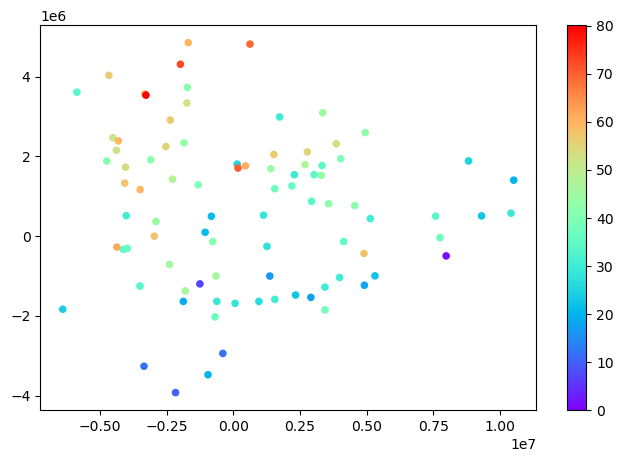

In [34]:
#%% 2D Visualisation
skip = 1
pims = pims_d[:,dim,::skip,::skip]

#tv ='pDLCO'
tv ='CPI'

idx = np.arange(len(col))
idx2 = np.arange(len(col))

#idx = np.where(np.logical_or((col==1),(col==2)))[0]
idx = np.where((np.logical_or(dat['group']==1,dat['group']==0)))[0]
idx2 = np.where((np.logical_or(dat['group']==2,dat['group']==0)))[0]

idx2 = np.where(~np.isnan(dat[tv]))[0]


A=pims[idx].reshape(len(idx),-1)
B=pims[idx2].reshape(len(idx2),-1)
Ya=col[idx]
Yb=col[idx2]
Yb=dat[tv][idx2]

method = "PCA"

print(len(Ya),len(Yb))

if method=="MDS":
    mds = manifold.MDS(n_components=2)
    X = mds.fit(A).transform(B)
elif method=="TSNE":
    X = manifold.TSNE(n_components=2,perplexity=6).fit(A).transform(B)   #pplx=6 for group1n2
elif method=="PCA":
    pca = PCA(n_components=2)
    X = pca.fit(A).transform(B)
    print("Explained variance:", pca.explained_variance_ratio_)
elif method=="LDA":
    lda = LinearDiscriminantAnalysis()
    X = lda.fit(A, Ya).transform(B)
elif method=="UMAP":
    met = 'euclidean'
    met = 'cosine'
    X = umap.UMAP(n_components=2, n_neighbors=5, metric=met).fit(A).transform(B)
else:
    print("Unknown method!")

#X=np.log(X)

# plot
plt.figure(figsize=(8,5))
if method=="LDA":
    biplot(X, Yb, lda.scalings_,n_comp=0)
else:
    biplot(X[:,:2], Yb, None,n_comp=0)

plt.savefig("{}_{}.jpg".format(method,ROI))
plt.show()

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     44.90
Date:                Thu, 29 Apr 2021   Prob (F-statistic):           4.93e-14
Time:                        14:11:06   Log-Likelihood:                -335.94
No. Observations:                  88   AIC:                             677.9
Df Residuals:                      85   BIC:                             685.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.7074      1.285     27.788      0.0

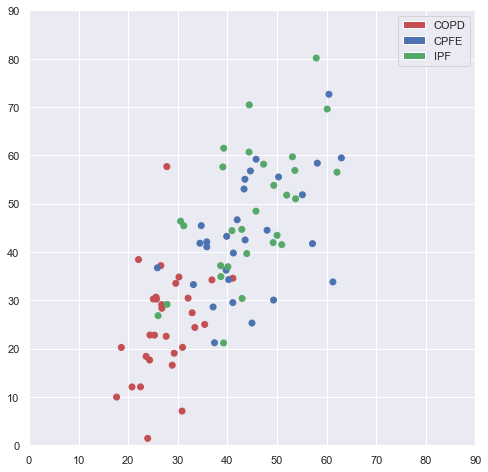

In [21]:
from sklearn import datasets, linear_model
import statsmodels.api as sm

regr = linear_model.LinearRegression()
#regr.fit(X,Yb)
#print(regr.coef_,regr.intercept_,regr.score(X,Yb))
regr = sm.OLS(Yb, sm.add_constant(X[:,:])).fit()
print(regr.summary(), regr.pvalues)
pred = regr.predict(sm.add_constant(X))
cols = ['r','b','k','g','y']
c = [cols[i] for i in col[idx2]]
plt.figure(figsize=(8,8))
plt.scatter(pred,Yb,  color=c)
#plt.axis([0,25,0,25],'equal')
plt.axis(xmin=0,xmax=90,ymin=0,ymax=90)
#plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)
select = [0,1,3]
recs = []
for i in select:
    recs.append(mpatches.Rectangle((0,0),1,1,fc=cols[i]))
plt.legend(recs,le.classes_[select],loc=0)
plt.savefig("PCA12-corr.jpg")

In [ ]:
#%% plot LDA weight
P = np.zeros((pims_d.shape[1],pims_d.shape[2],pims_d.shape[3]))
P[mask] = np.linalg.norm(lda.scalings_,axis=1)
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.imshow((P[i]))
plt.savefig(root+"LDA_weights.jpg")


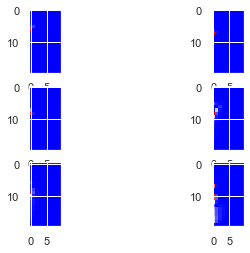

In [25]:
pc = pca.components_.reshape(-1,*pims_d.shape[1:])
for i in range(3*len(pc)):
    ax = plt.subplot(3,len(pc),i+1)
    ax.imshow((pc[i//3,i%3]),cmap='bwr',vmin=0)
plt.savefig("PC_pim.jpg")


In [ ]:
#%% classification
target = 1
idx = np.arange(len(col))
#idx = np.where(np.logical_or((col==1),(col==2)))[0]
Y = col[idx] #==target
#Y = np.logical_or((col==0),(col==2))

clf = RandomForestClassifier(max_depth=4, n_estimators=400, random_state=0, oob_score=True)

if False:
    # train-test split
    (trainX, testX, trainY, testY) = train_test_split(pims, Y, test_size = 0.30, random_state = 0)
    clf.fit(trainX, trainY)
    predY = clf.predict(testX)
    # classification results
    print("Confusion matrix\n",confusion_matrix(testY,predY))
    print(classification_report(testY,predY))

#OOB
#clf.fit(pims,Y)
clf.fit(pims[idx],Y)
oob_pred=clf.oob_decision_function_.argmax(axis=1)
print("Confusion matrix\n",confusion_matrix(Y,oob_pred))
print(classification_report(Y,oob_pred))
print(le.classes_, sum(Y==2))

#%%
id = np.where((Y==target) * (Y != oob_pred))
error1 = [(i,names[i],le.classes_[oob_pred[i]],weight[i]) for i in id[0]]
id = np.where((oob_pred==target) * (Y != oob_pred))
error2 = [(i,names[i],le.classes_[oob_pred[i]],weight[i]) for i in id[0]]
np.savetxt("error.csv",np.array(error1+error2),fmt='%s',delimiter=",")
#p = np.stack([names,le.inverse_transform(oob_pred)])
#np.savetxt("pred.csv",p.T,fmt='%s')
#np.savetxt("oob.csv",clf.oob_decision_function_,fmt='%1.4f',delimiter=",")

In [ ]:
fname = None
_ = tree_clf(pims,col,depth=2,verbose=True,plot_roc=False)
P = np.zeros((pims_d.shape[1],pims_d.shape[2],pims_d.shape[3]))
importance = np.zeros( (np.sum(mask)) )
importance[[40,197]]=1
P[mask]=importance
#for i in range(3):
#    ax = plt.subplot(1,3,i+1)
#    ax.imshow((P[i]))
print(np.where(P>0))

In [ ]:
#%% variable importance by tree
clf = ExtraTreesClassifier(n_estimators=100,random_state=0, bootstrap=True, oob_score=True)
target = 2
Y = col #==target

clf.fit(pims, Y)
oob_pred=clf.oob_decision_function_.argmax(axis=1)
print("Confusion matrix\n",confusion_matrix(Y,oob_pred))
print(classification_report(Y,oob_pred))
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)

n=10
indices = np.argsort(importances)[::-1][:n]
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

P = np.zeros((pims_d.shape[1],pims_d.shape[2],pims_d.shape[3]))
P[mask] = importances
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.imshow((P[i]))
plt.savefig("importance_{}.jpg".format(le.classes_[target]))

In [ ]:
#%% variable importance by logistic regression
target = 0
Y = (col==target)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(pims, Y)
pred = logreg.predict(pims)
print("Confusion matrix\n",confusion_matrix(Y,pred))
print(classification_report(Y,pred))

P = np.zeros((pims_d.shape[1],pims_d.shape[2],pims_d.shape[3]))
P[mask] = logreg.coef_[0]
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.imshow((P[i]),vmin=-2.5,vmax=2.5)
plt.savefig("coeff_{}.jpg".format(le.classes_[target]))

#logreg = LogisticRegression(C=1e5)
#logreg.fit(pims, col)
#logreg.coef_



In [ ]:
# feature selection with Boruta: takes a few minutes
from boruta import BorutaPy
feat_selector = BorutaPy(clf, verbose=1)

target = 1
print(le.classes_[target])
Y = (col == target)
feat_selector.fit(pims,Y)

X_filtered = feat_selector.transform(pims)
clf.fit(X_filtered, Y)
oob_pred=clf.oob_decision_function_.argmax(axis=1)
print("Confusion matrix\n",confusion_matrix(Y,oob_pred))
print(classification_report(Y,oob_pred))

P = np.zeros((pims_d.shape[1],pims_d.shape[2],pims_d.shape[3]))
P[mask] = feat_selector.support_
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.imshow((P[i]))
#%% decision boundary
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lda.fit(pims, Y)
X = lda.transform(pims)

fig, axes = plt.subplots(nrows=2, figsize=(16, 9))
cm = plt.cm.RdBu

for i, (cname, clf) in enumerate([("LDA", lda), ("QDA", qda)]):
    clf.fit(X, Y)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    axes[i].scatter(X[:,0], X[:,1], color=scalarMap.to_rgba(col))
    axes[i].contourf(xx, yy, Z, cmap=cm, alpha=.2)
plt.show()

